# 调参

In [ ]:
import os
import sys
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
current_path = os.getcwd()

# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))
# Importing the custom module
from Utools.draw import plot_feature_importance
from Utools.SingleModel import SingleModel


In [ ]:
# Load data (assuming you have dft_train_X, dft_train_y)
file_dir = os.path.join(current_path, './Data')
# Load dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))

In [6]:
# 从dft_train_X中抽取出一份验证集
mp_unique_comp = dft_train['composition'].unique()
len(mp_unique_comp)

8237

In [11]:
import random
# 从mp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(mp_unique_comp)), round(dft_train.shape[0]*0.1))
mp_val_comp = mp_unique_comp[random_index]
dft_train_set = dft_train[~dft_train['composition'].isin(mp_val_comp)]
dft_val_set = dft_train[dft_train['composition'].isin(mp_val_comp)]
print(f'MP训练集大小：{len(dft_train_set)}')
print(f'MP验证集大小：{len(dft_val_set)}')

MP训练集大小：7437
MP验证集大小：831


In [12]:
# Prepare data
dft_train_X = dft_train_set.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train_set['band_gap']
# 
dft_val_X = dft_val_set.drop(columns=['composition', 'band_gap'])
dft_val_y = dft_val_set['band_gap']

dft_train_X.shape, dft_train_y.shape, dft_val_X.shape, dft_val_y.shape

((7437, 132), (7437,), (831, 132), (831,))

## 7. SVR

In [20]:
# Define the model
MODEL_NAME = 'SVR'

In [25]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")
# create a pipeline with standard scaler
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

# define the parameter grid 
param_distributions = {
    'svr__C': [0.1, 1, 10, 25, 50, 75, 100],
    'svr__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
    'svr__epsilon': [0.01, 0.05, 0.07, 0.5, 0.1, 1],
}


random_search = RandomizedSearchCV(estimator=svr_pipe, param_distributions=param_distributions,
                n_iter=5, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)

['DFT SVR'] HP optimazation begin...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_svr__C', 'param_svr__gamma', 'param_svr__epsilon',
                                 'train_rmse', 'test_rmse']]
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'SVR_dft_hp.csv'), index=False)
results_sorted.head()

NameError: name 'random_search' is not defined

In [ ]:
# 绘制超参数搜索结果图，多幅图，每幅图展示一个超参数对模型性能的影响
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(results_sorted['param_svr__C'], results_sorted['test_rmse'], marker='o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs C')
plt.subplot(1, 3, 2)    
plt.plot(results_sorted['param_svr__gamma'], results_sorted['test_rmse'], marker='o')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Gamma')
plt.subplot(1, 3, 3)
plt.plot(results_sorted['param_svr__epsilon'], results_sorted['test_rmse'], marker='o')
plt.xscale('log')   
plt.xlabel('Epsilon')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Epsilon')
plt.tight_layout()

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   8.8s
Model training completed!
[Train Error] Evaluating DFT SVR on DFT train set:


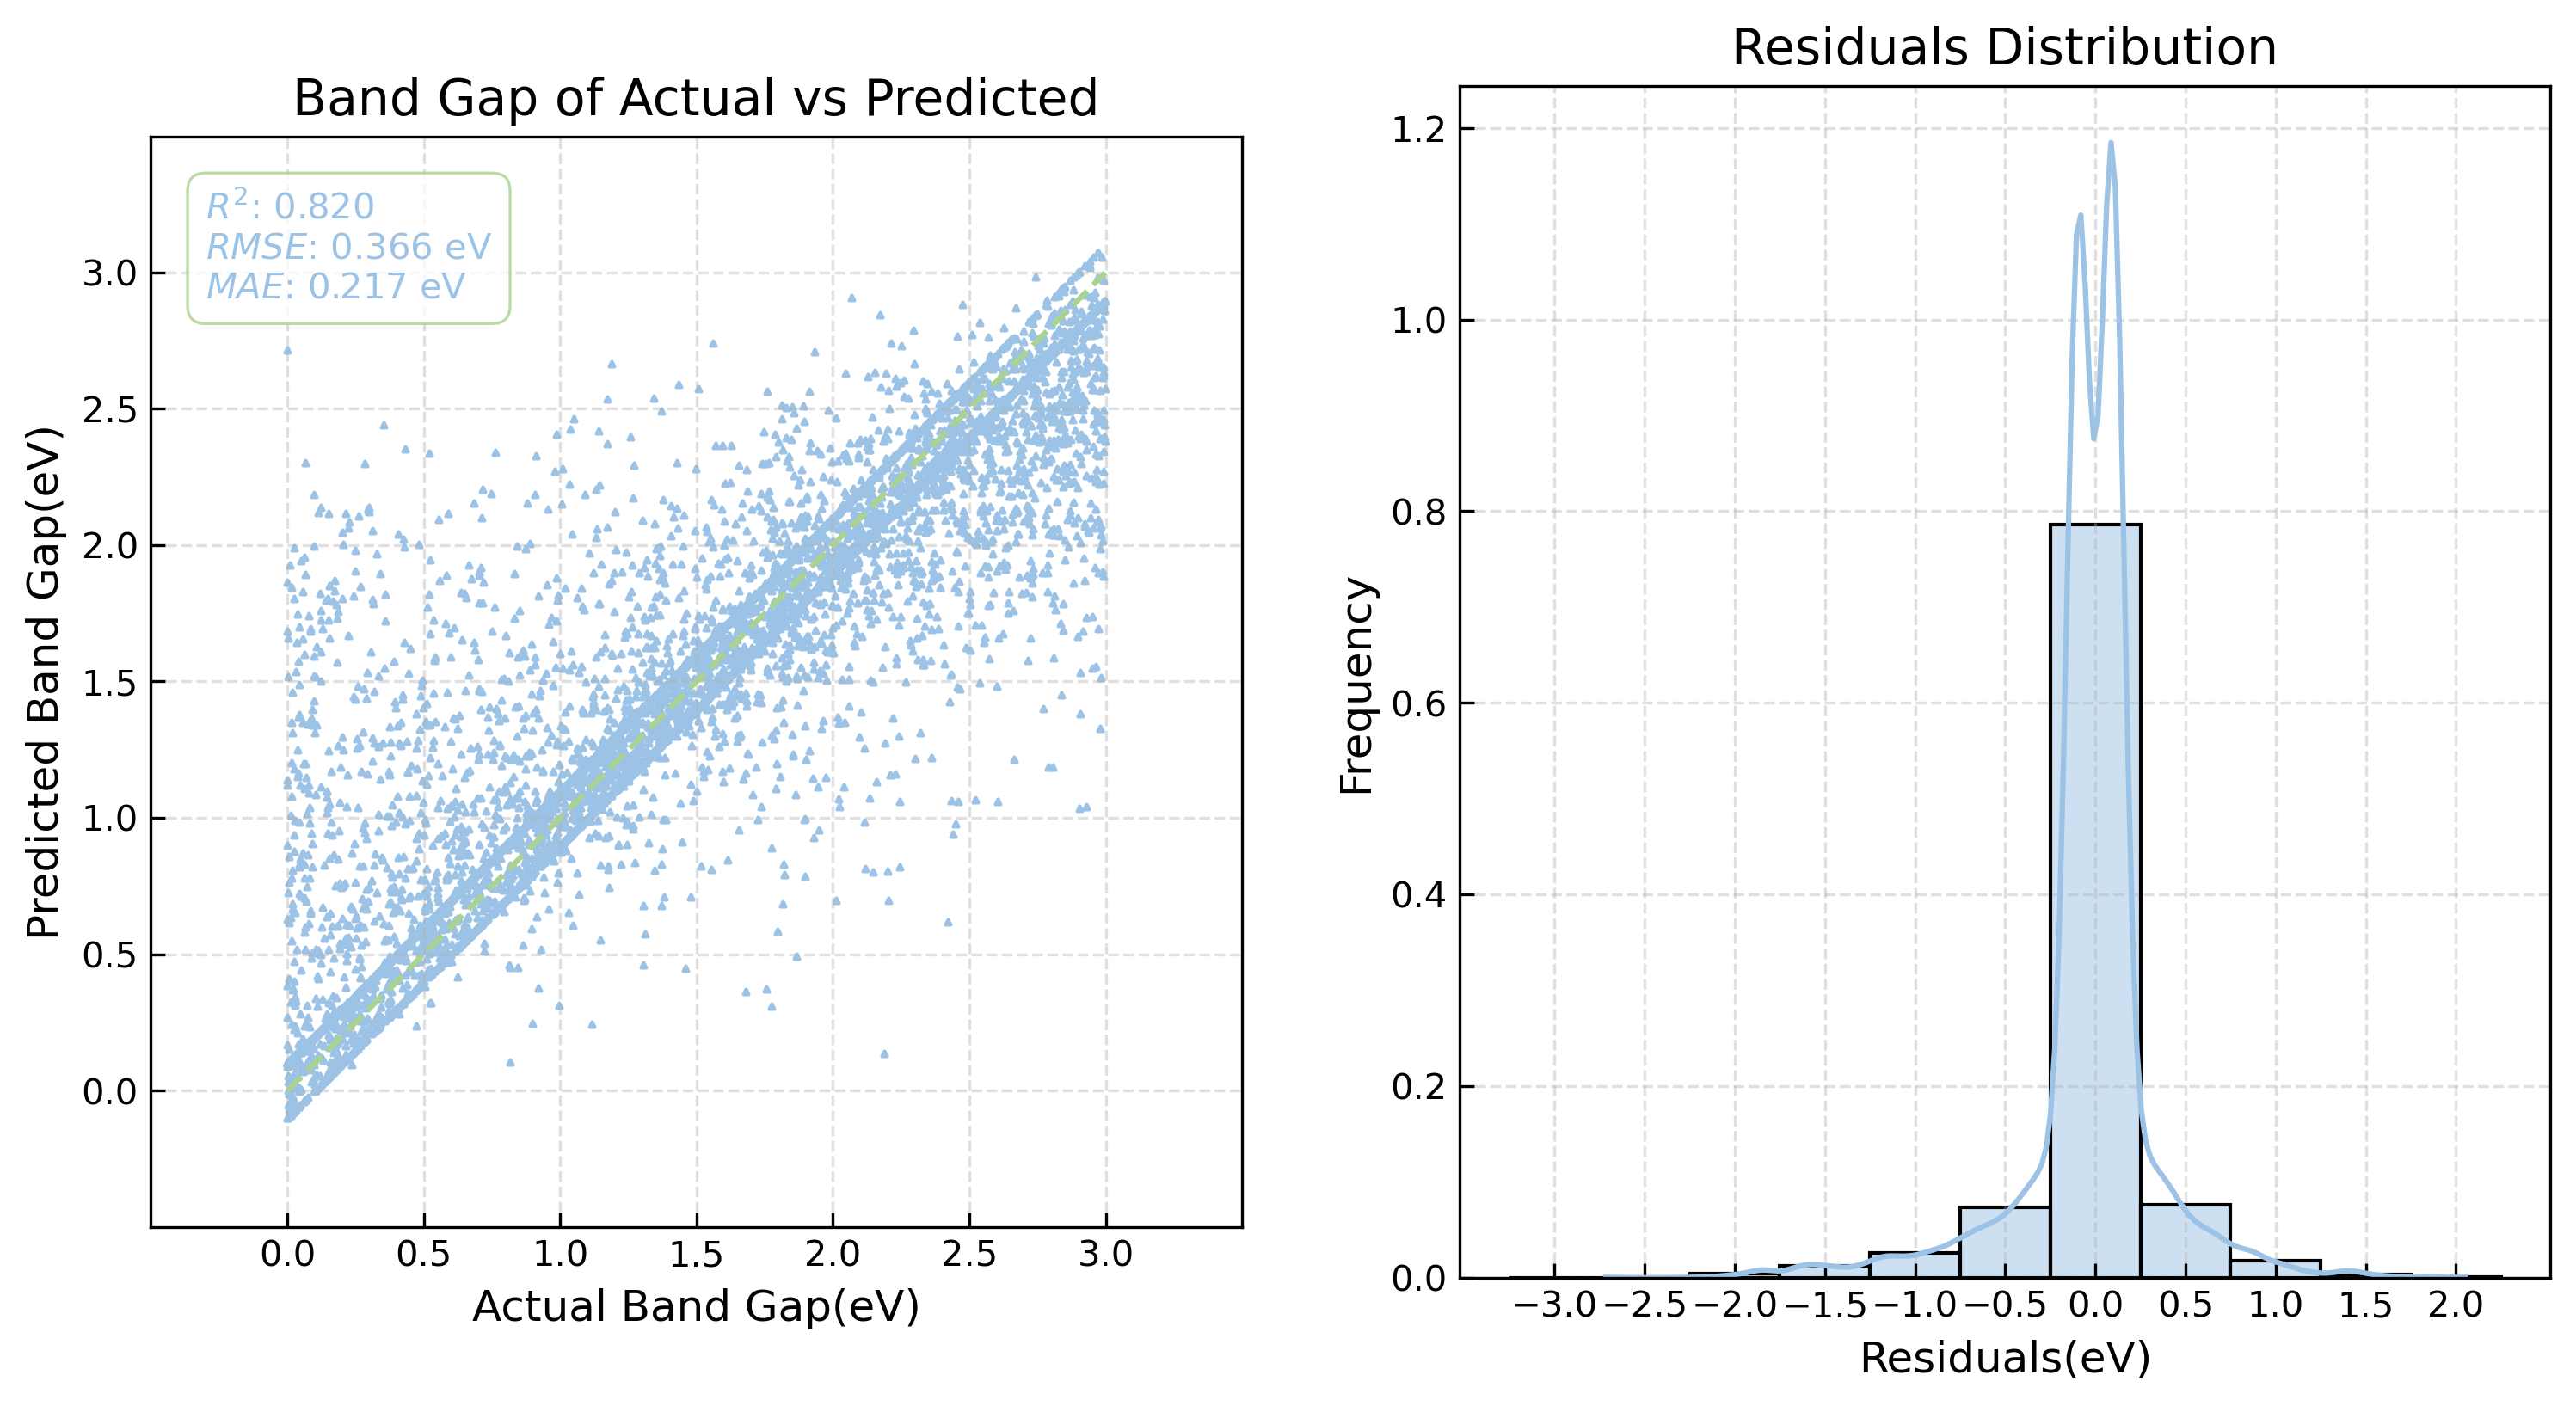


Model Evaluation Results:
Test set size: 7437
Test set: R²: 0.8201 RMSE: 0.3660 MAE: 0.2170 MAPE: 1212.4865%
[Valid Error] Evaluating DFT SVR on DFT valid set:


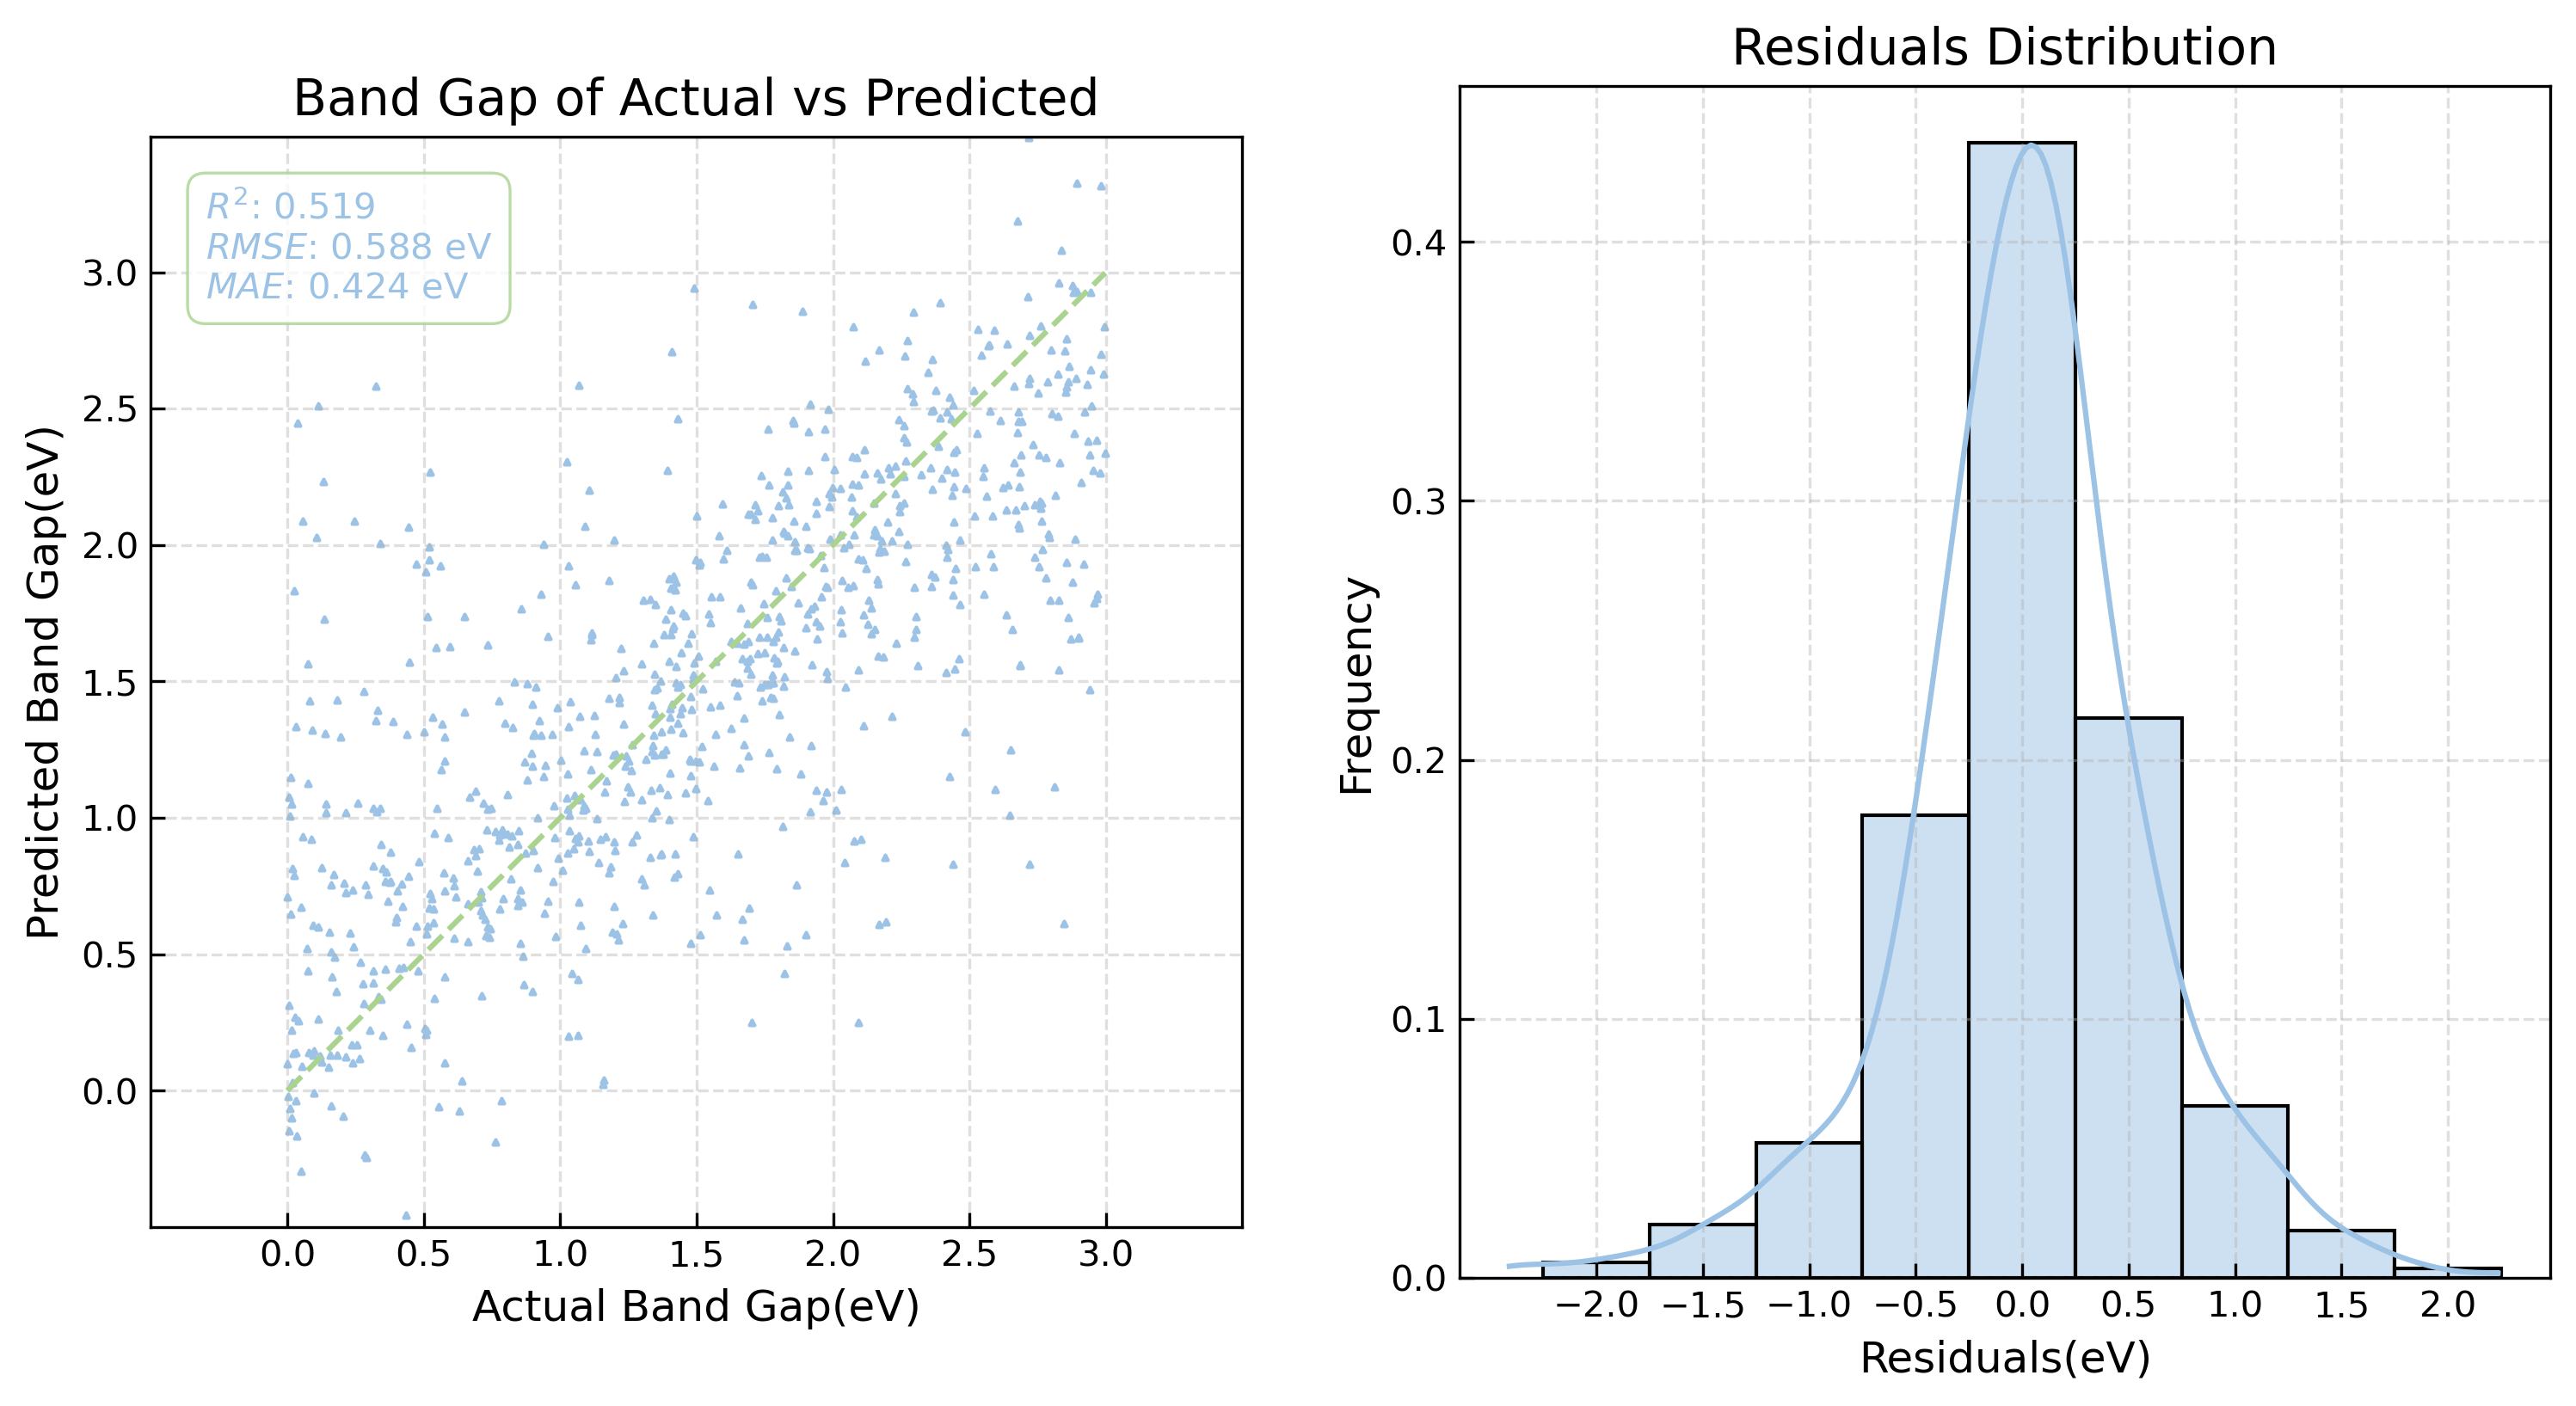


Model Evaluation Results:
Test set size: 831
Test set: R²: 0.5186 RMSE: 0.5876 MAE: 0.4243 MAPE: 1063.6940%


In [ ]:
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])
svr = SVR(kernel='rbf', C=best_params['svr__C'], gamma=best_params['svr__gamma'], epsilon=best_params['svr__epsilon'])
# Create a SingleModel instance
svr_model = SingleModel(clone(svr), random_state=RANDOM_SEED)

# Train the model
svr_model.train(dft_train_X, dft_train_y)


# Evaluate the model
# evaluate on the dft train set
print(f"[Train Error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = svr_model.evaluate(dft_train_X, dft_train_y,fig_show=True)
model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {MODEL_NAME}",
    'Error_Type': 'Train',
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
# evaluate on the dft valid set
print(f"[Valid Error] Evaluating DFT {MODEL_NAME} on DFT valid set:")

metrics = svr_model.evaluate(dft_val_X, dft_val_y,fig_show=True)
model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {MODEL_NAME}",
    'Error_Type': 'Valid',
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}


In [24]:
model_metrics

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE,MAPE
0,Single SVR,Train,dft,dft,0.820074,0.366044,0.217038,1212.486507
1,Single SVR,Valid,dft,dft,0.518588,0.587571,0.424326,1063.693951
